Using LSTM with a convolutional autoencoder

# Preprocessing

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt



def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    Returns every 4th frame as we want to make a sequential model
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 128, 128, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(128, 128))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(128, 128))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

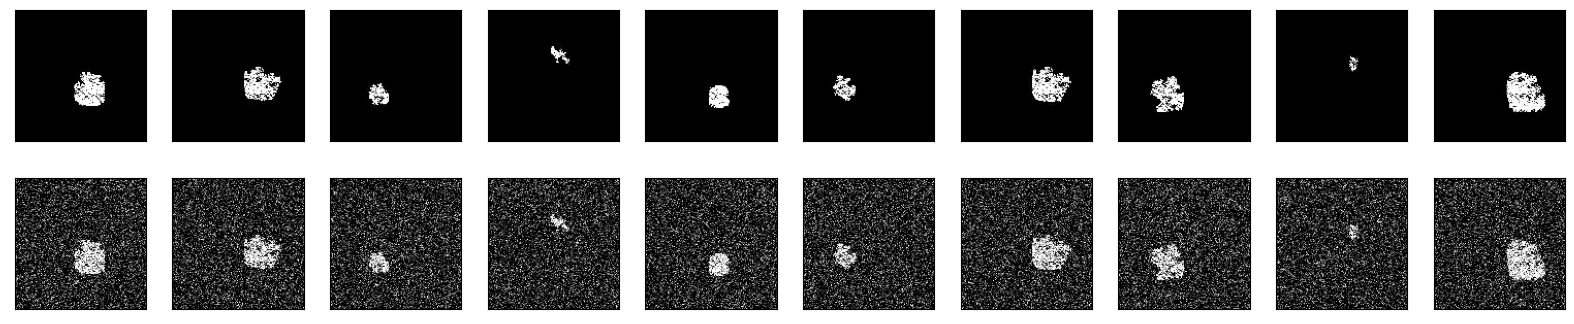

In [5]:
#loading in the data


import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
data = [] 

for i in range(41):
    for j in range(16):
        image_name = 'video%s_frame_%s.jpg' % (i,j)
        im = mpimg.imread('%s' % (image_name))
        #plt.imshow(im)
        #plt.show()   #these commented out lines of code will print out all the images
        im = cv2.imread(image_name, 0).flatten()  #read image as grayscale. Set second parameter to 1 if rgb is required 
        data.append(im)#value of 0 = black, 255 = white
data = np.asarray(data)  


test_data = []
for i in range(8):
    for j in range(16):
        image_name = 'video%s_frame_%s.jpg' % (i+41,j)
        im = mpimg.imread('%s' % (image_name))
        #plt.imshow(im)
        #plt.show()   
        im = cv2.imread(image_name, 0).flatten()
        test_data.append(im)
        
test_data = np.asarray(test_data)


#splitting the data into timesteps of 4 images
#i.e give the training the first 3 images and predict the 4th 
#validation data will have the final image in the 4 image time step
#Hence validation data should have every 4th image
n = 4
validation_data = preprocess(data[n-1::n]) #validation will be every 4th frame starting from the 4th
test_validation_data = preprocess(test_data[n-1::n])

#preprocess the rest of the data
data = preprocess(data)
test_data = preprocess(test_data)

#add noise
noisy_data = noise(data)
noisy_test_data = noise(test_data) 

#display images
display(data, noisy_data)

#arrays to separate images into 3 time step batches 
#do this by reshaping the array then removing the 4th image
noisy_data = np.reshape(noisy_data, (164,4,128,128,1)) 
noise_data = []
for i in range(len(noisy_data)):
    noise_data.append(noisy_data[i,:3,:,:,:])
noise_data = np.array(noise_data)

#do the same for the test data
noisy_test_data = np.reshape(noisy_test_data, (32,4,128,128,1))
test_data = np.reshape(test_data, (32,4,128,128,1))
test_data1 = []
noise_test_data1 = []
for i in range(len(noisy_test_data)):
    test_data1.append(test_data[i,:3,:,:,:])
    noise_test_data1.append(noisy_test_data[i,:3,:,:,:])
test_data1 = np.array(test_data1)
noise_test_data1 = np.array(noise_test_data1)



# The Model

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
import numpy as np
import pylab as plt

In [77]:
#Encoder part of model
cnn = keras.models.Sequential()
cnn.add(layers.Conv2D(32, (3, 3), strides= 2, activation="relu", padding="same", input_shape = (128,128,1)))
cnn.add(layers.MaxPooling2D((2, 2), padding="same"))
cnn.add(layers.Conv2D(32, (3, 3),strides= 2, activation="relu", padding="same"))
#cnn.add(layers.MaxPooling2D((2, 2), padding="same"))
cnn.add(layers.Conv2D(1,(3,3), strides=1, activation ="relu", padding="same"))
cnn.compile(optimizer = "adam", loss = "binary_crossentropy")
cnn.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_36 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 conv2d_37 (Conv2D)          (None, 16, 16, 1)         289       
                                                                 
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
_________________________________________________________________


In [76]:
#LSTM part of model
convlstm = keras.models.Sequential()
convlstm.add(layers.ConvLSTM2D(64, kernel_size = (1,1), strides = 2, return_sequences= True, input_shape=(3,16,16,1)))
convlstm.add(layers.ConvLSTM2D(32, kernel_size = (1,1), return_sequences= False))
convlstm.add(layers.Conv2D(1, kernel_size = (3,3), activation = 'relu', padding = "same"))
convlstm.compile(optimizer = "adam", loss = "binary_crossentropy")
convlstm.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_52 (ConvLSTM2D)  (None, 3, 8, 8, 64)      16896     
                                                                 
 conv_lstm2d_53 (ConvLSTM2D)  (None, 8, 8, 32)         12416     
                                                                 
 conv2d_34 (Conv2D)          (None, 8, 8, 1)           289       
                                                                 
Total params: 29,601
Trainable params: 29,601
Non-trainable params: 0
_________________________________________________________________


In [70]:
#Decoder part of model
cnn2 = keras.models.Sequential()
cnn2.add(layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same", input_shape = (8,8,1)))
cnn2.add(layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"))
cnn2.add(layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same"))
cnn2.add(layers.Conv2DTranspose(1, (3, 3), strides=2, activation="relu", padding="same"))
#cnn2.add(layers.Conv2DTranspose(1, (3, 3), strides=2, activation="relu", padding="same"))

cnn2.compile(optimizer = "adam", loss = "binary_crossentropy")
cnn2.summary()

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_40 (Conv2D  (None, 16, 16, 32)       320       
 Transpose)                                                      
                                                                 
 conv2d_transpose_41 (Conv2D  (None, 32, 32, 32)       9248      
 Transpose)                                                      
                                                                 
 conv2d_transpose_42 (Conv2D  (None, 64, 64, 32)       9248      
 Transpose)                                                      
                                                                 
 conv2d_transpose_43 (Conv2D  (None, 128, 128, 1)      289       
 Transpose)                                                      
                                                                 
Total params: 19,105
Trainable params: 19,105
Non-tra

In [72]:
from tensorflow.keras.models import Model
#putting sections together
main_input = layers.Input(shape = (3,128,128,1))

model = layers.TimeDistributed(cnn)(main_input)
model = convlstm(model)
model = cnn2(model)

final_model = Model(inputs = main_input, outputs = model)
final_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ['mse', metrics.RootMeanSquaredError()])
final_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 3, 128, 128, 1)]  0         
                                                                 
 time_distributed_8 (TimeDis  (None, 3, 64, 64, 1)     609       
 tributed)                                                       
                                                                 
 sequential_39 (Sequential)  (None, 8, 8, 1)           62625     
                                                                 
 sequential_40 (Sequential)  (None, 128, 128, 1)       19105     
                                                                 
Total params: 82,339
Trainable params: 82,339
Non-trainable params: 0
_________________________________________________________________


In [73]:
print(np.shape(noise_data), np.shape(validation_data))
print(np.shape(noise_test_data1), np.shape(test_validation_data))
history = final_model.fit(
    x=noise_data,
    y=validation_data,
    epochs=50,
    batch_size=164,
    shuffle=True,
    validation_data=(test_data1, test_validation_data)
)

(164, 3, 128, 128, 1) (164, 128, 128, 1)
(32, 3, 128, 128, 1) (32, 128, 128, 1)
Epoch 1/50
1/1 [==============================] - 7s 7s/step - loss: 0.3767 - mse: 0.0224 - root_mean_squared_error: 0.1497 - val_loss: 0.0972 - val_mse: 0.0141 - val_root_mean_squared_error: 0.1189
Epoch 2/50
1/1 [==============================] - 3s 3s/step - loss: 0.1522 - mse: 0.0223 - root_mean_squared_error: 0.1494 - val_loss: 0.0887 - val_mse: 0.0141 - val_root_mean_squared_error: 0.1187
Epoch 3/50
1/1 [==============================] - 3s 3s/step - loss: 0.1375 - mse: 0.0222 - root_mean_squared_error: 0.1491 - val_loss: 0.0849 - val_mse: 0.0140 - val_root_mean_squared_error: 0.1185
Epoch 4/50
1/1 [==============================] - 3s 3s/step - loss: 0.1303 - mse: 0.0221 - root_mean_squared_error: 0.1488 - val_loss: 0.0828 - val_mse: 0.0140 - val_root_mean_squared_error: 0.1184
Epoch 5/50
1/1 [==============================] - 3s 3s/step - loss: 0.1257 - mse: 0.0221 - root_mean_squared_error: 0.1486 

Epoch 42/50
1/1 [==============================] - 3s 3s/step - loss: 0.1113 - mse: 0.0216 - root_mean_squared_error: 0.1469 - val_loss: 0.0796 - val_mse: 0.0139 - val_root_mean_squared_error: 0.1179
Epoch 43/50
1/1 [==============================] - 3s 3s/step - loss: 0.1109 - mse: 0.0215 - root_mean_squared_error: 0.1468 - val_loss: 0.0789 - val_mse: 0.0138 - val_root_mean_squared_error: 0.1176
Epoch 44/50
1/1 [==============================] - 3s 3s/step - loss: 0.1103 - mse: 0.0215 - root_mean_squared_error: 0.1466 - val_loss: 0.0779 - val_mse: 0.0138 - val_root_mean_squared_error: 0.1174
Epoch 45/50
1/1 [==============================] - 3s 3s/step - loss: 0.1096 - mse: 0.0214 - root_mean_squared_error: 0.1463 - val_loss: 0.0767 - val_mse: 0.0137 - val_root_mean_squared_error: 0.1171
Epoch 46/50
1/1 [==============================] - 3s 3s/step - loss: 0.1088 - mse: 0.0213 - root_mean_squared_error: 0.1461 - val_loss: 0.0754 - val_mse: 0.0136 - val_root_mean_squared_error: 0.1167


## Analysis of 4x4

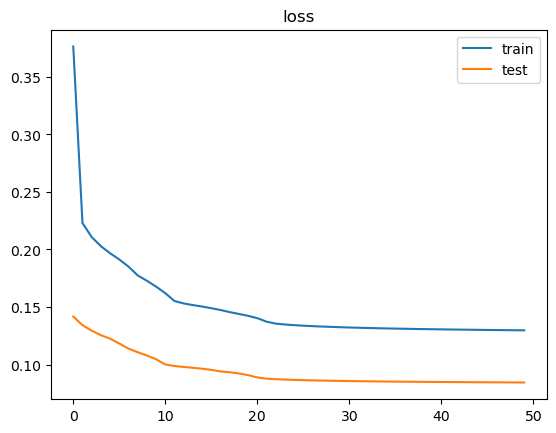

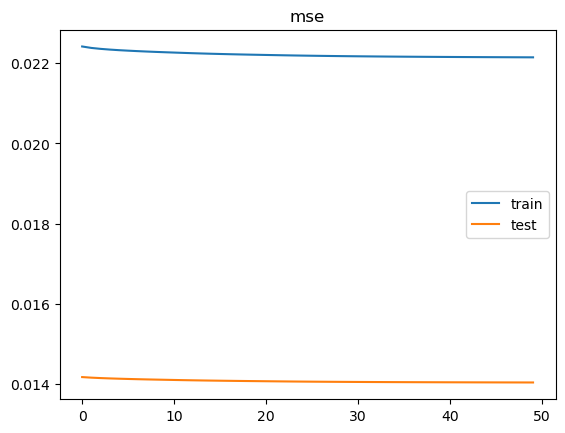

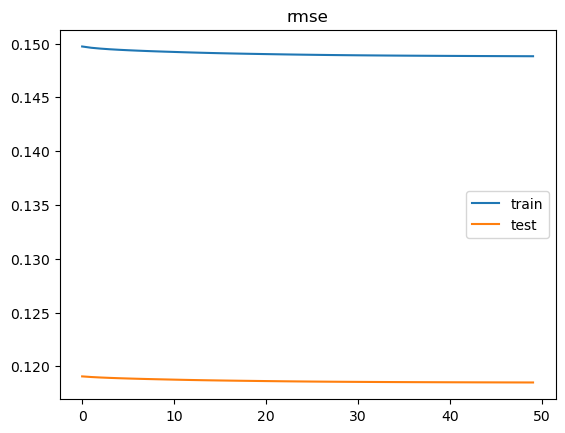

In [22]:
#For binary cross entropy loss function compressing to 4x4 spatial dimensions
plt.title('loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

plt.title('mse')
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='test')
plt.legend()
plt.show()

plt.title('rmse')
plt.plot(history.history['root_mean_squared_error'], label='train')
plt.plot(history.history['val_root_mean_squared_error'], label='test')
plt.legend()
plt.show()

Using loss function of binary crossentropy we get a 
loss = 0.1298     and val_loss = 0.0845
MSE = 0.0221      and val_MSE = 0.0140
RMSE = 0.1488     and val_RMSE = 0.1185



1/1 [==============================] - 1s 574ms/step
(32, 128, 128, 1)
(32, 3, 128, 128, 1)


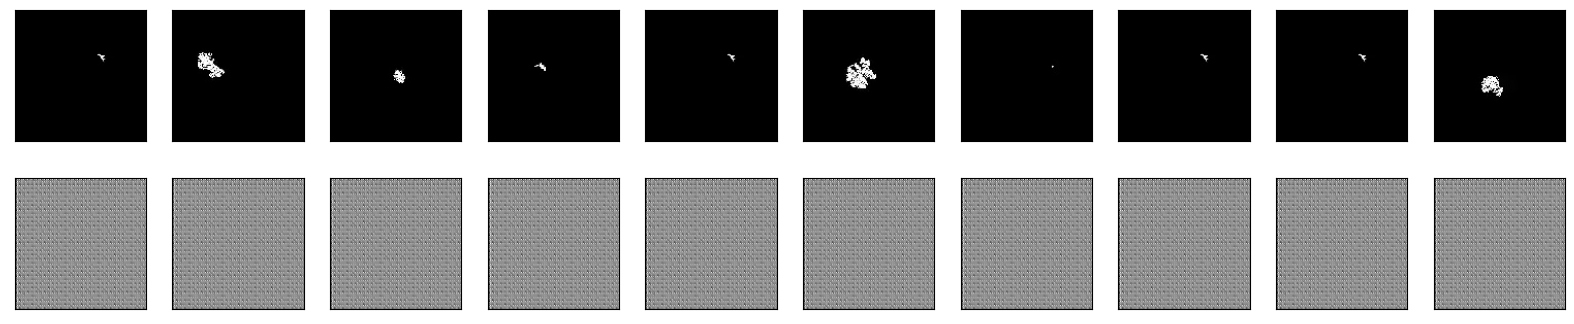

In [23]:
#For binary cross entropy as the loss function

predictions = final_model.predict(test_data1)

print(np.shape(predictions))
print(np.shape(test_data1))
display(test_validation_data, predictions)

Currently, it isn't predicting very well, as it is just producing grey plots for every image. This may be due to the model compressing the data too much (currently compressing to 4x4)

## Analysis of decompressing to 8x8 spatial dimensions

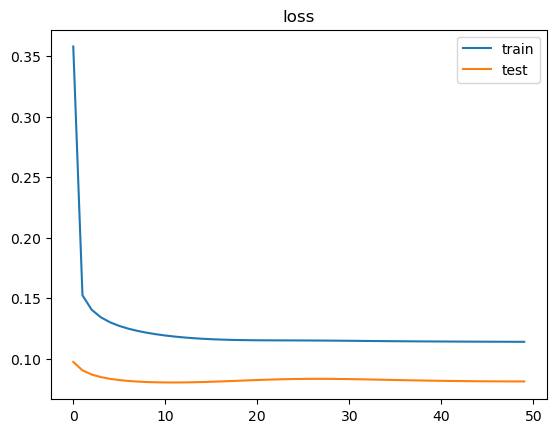

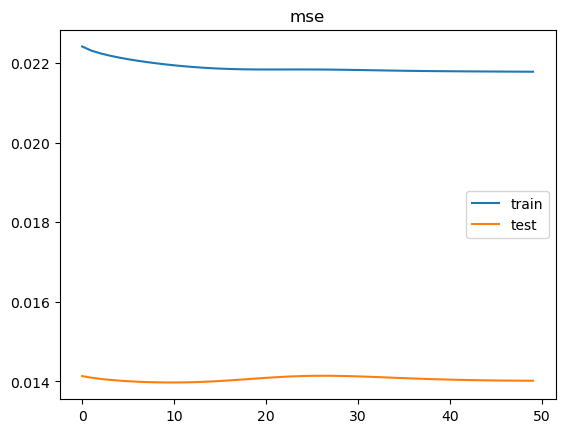

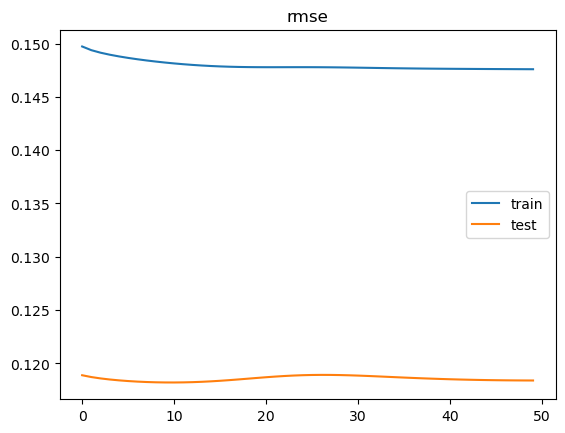

In [38]:
#For binary cross entropy loss function compressing to 8x8 spatial dimensions
plt.title('loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

plt.title('mse')
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='test')
plt.legend()
plt.show()

plt.title('rmse')
plt.plot(history.history['root_mean_squared_error'], label='train')
plt.plot(history.history['val_root_mean_squared_error'], label='test')
plt.legend()
plt.show()

Using loss function of binary crossentropy we get a 
loss: 0.1139 - mse: 0.0218 - root_mean_squared_error: 0.1476 - val_loss: 0.0812 - val_mse: 0.0140 - val_root_mean_squared_error: 0.1184

1/1 [==============================] - 0s 294ms/step
(32, 128, 128, 1)
(32, 3, 128, 128, 1)


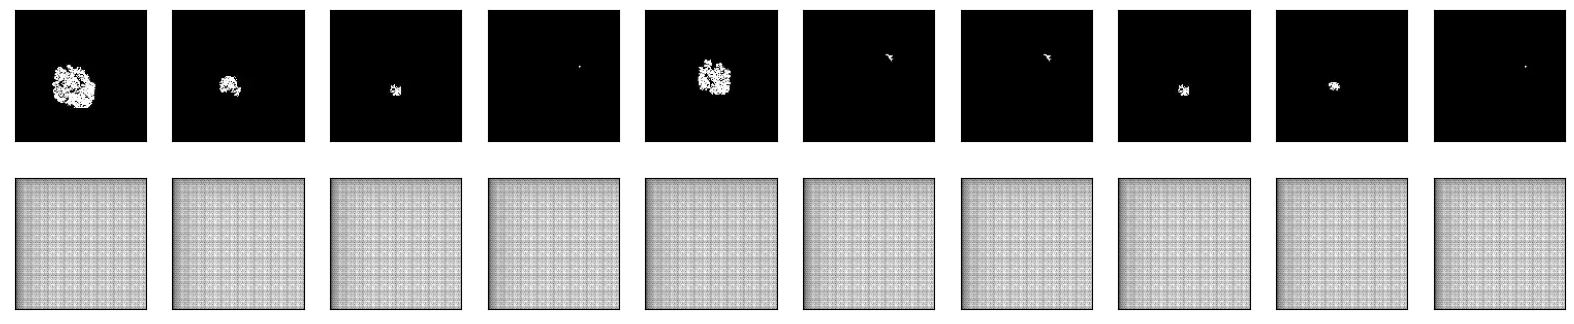

In [39]:
#For binary cross entropy as the loss function

predictions = final_model.predict(test_data1)

print(np.shape(predictions))
display(test_validation_data, predictions)

Although the metrics improved the output does not see much of an improvement. 
Now to try to improve the predicted images I will reduce the spatial dimensions less with the Encoder and more with the Conv2DLSTM. (Currently Encoder reducing spatial dimensions to 8x8 and the Conv2DLSTM isn't reducing the spatial dimensions.)

Now using the conv2D to reduce spatial dimensions from 128x16 to 16x16 and Conv2DLSTM to reduce the spatial dimensions to 8x8.
loss: 0.0922 - mse: 0.0197 - root_mean_squared_error: 0.1403 - val_loss: 0.0656 - val_mse: 0.0124 - val_root_mean_squared_error: 0.1112

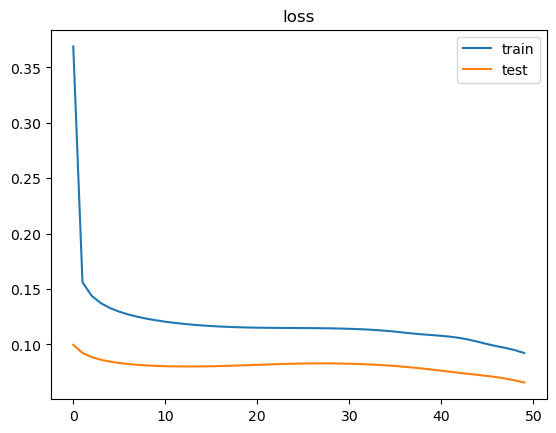

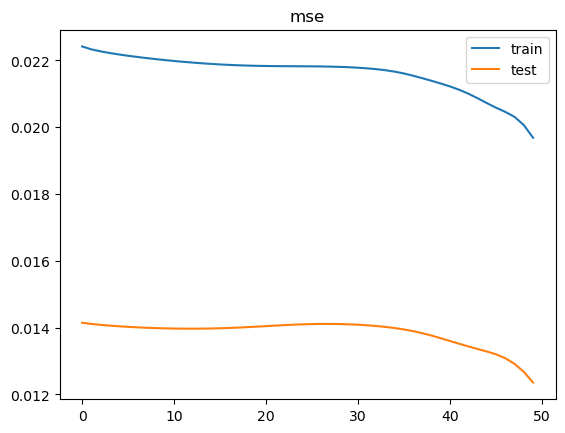

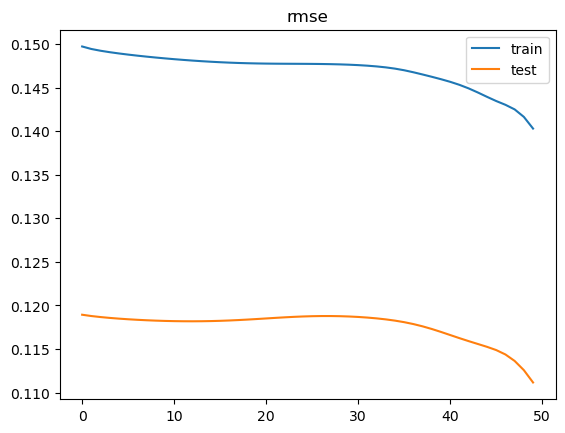

In [62]:
plt.title('loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

plt.title('mse')
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='test')
plt.legend()
plt.show()

plt.title('rmse')
plt.plot(history.history['root_mean_squared_error'], label='train')
plt.plot(history.history['val_root_mean_squared_error'], label='test')
plt.legend()
plt.show()

1/1 [==============================] - 0s 388ms/step
(32, 128, 128, 1)


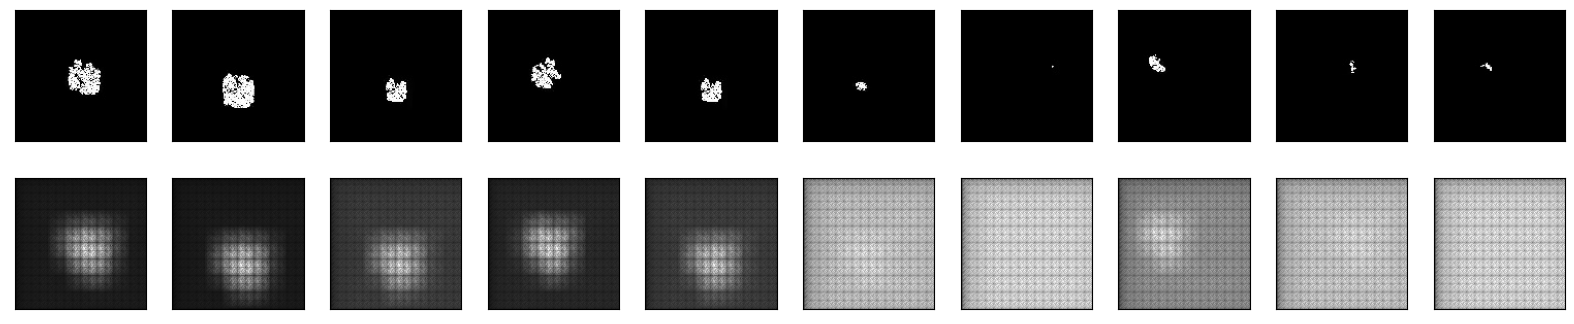

In [63]:
predictions = final_model.predict(test_data1)

print(np.shape(predictions))
display(test_validation_data, predictions)

These predictions look better. Now doing this again but using LSTM layers to do decompression from 64x64 to 8x8 (so conv2D layers only decompress images from 128x128 to 64x64).

This took considerably longer to train per epoch. 
Metrics:
loss: 0.1038 - mse: 0.0210 - root_mean_squared_error: 0.1448 - val_loss: 0.0703 - val_mse: 0.0134 - val_root_mean_squared_error: 0.1157

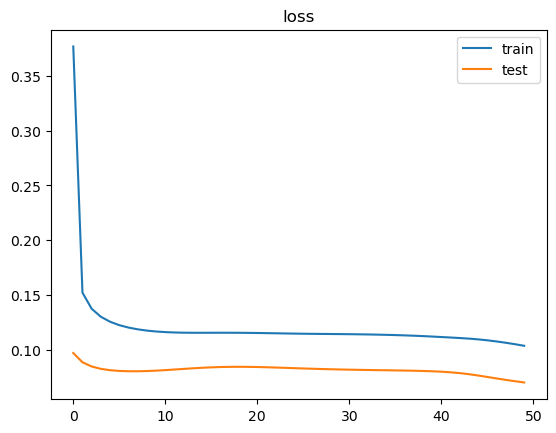

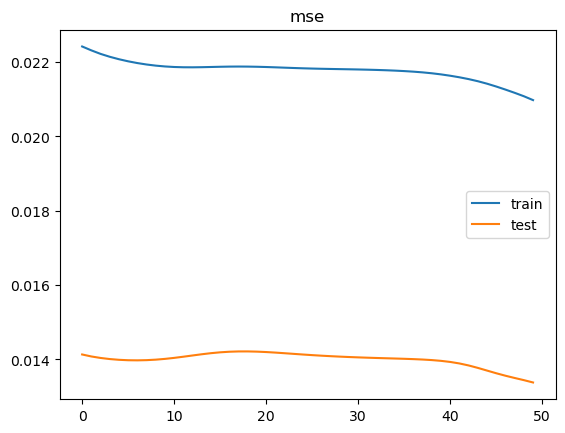

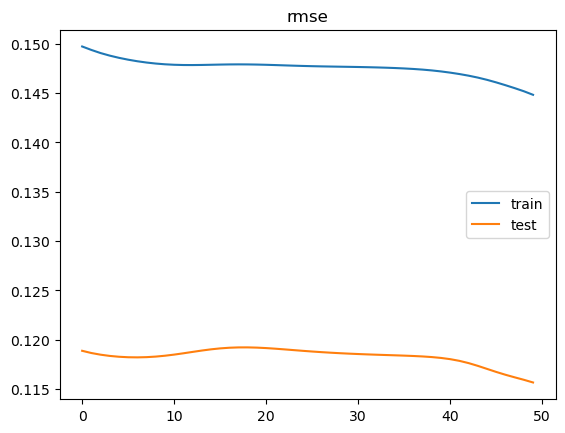

In [74]:
plt.title('loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

plt.title('mse')
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='test')
plt.legend()
plt.show()

plt.title('rmse')
plt.plot(history.history['root_mean_squared_error'], label='train')
plt.plot(history.history['val_root_mean_squared_error'], label='test')
plt.legend()
plt.show()

1/1 [==============================] - 1s 546ms/step
(32, 128, 128, 1)


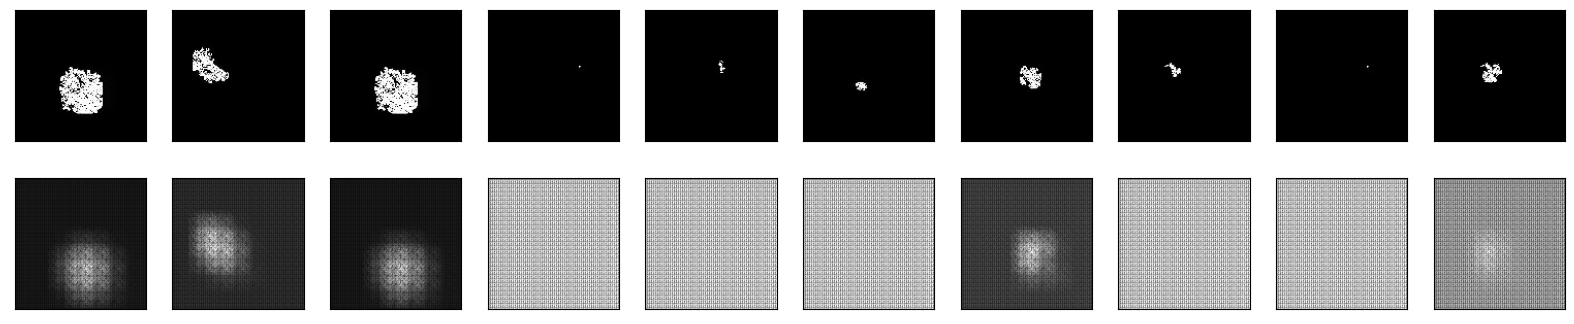

In [75]:
predictions = final_model.predict(test_data1)

print(np.shape(predictions))
display(test_validation_data, predictions)

As we can see, the best performing architecture of the neural networks was using the convolutional neural network to reduce spatial dimensions from 128x16 to 16x16 and Conv2DLSTM to reduce the spatial dimensions to 8x8.
(This is the architecture the model is currently in)